In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import scipy.io as sio
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images.mat'
savePath = '../Results/Spectral/'

experiment = 'MultiClass_2D_AlexNet_Full'

filename = savePath+'CNN_2D_results_'+experiment+'.mat'
title = 'Categorical Multiclass Emotion Classification - Full'
padding = 'same'
epochs = 30
learn_rate = 0.0001
optimizer = 'Adam'
weight_decay = 0.000001
momentum = 0.9
batch_size = 32
foldNum = 10

matContent = sio.loadmat(dataPath)
features = matContent['full_feat_img']
labels = np.squeeze(matContent['full_multi_labels'])
features = np.swapaxes(features,1,3)
features = np.swapaxes(features,1,2)
labels[labels == 6]=0
labels[labels < 0] = 0
#labels = labels.astype(int)

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels)

print('Features:', features.shape)
print('Labels:', labels_categorical.shape)
print('Number of classes:', class_num)

input_shape = (features.shape[1], features.shape[2], features.shape[3])
print('Input shape:', input_shape)

print('Unique labels:', np.unique(labels))

Features: (14800, 32, 32, 3)
Labels: (14800, 6)
Number of classes: 6
Input shape: (32, 32, 3)
Unique labels: [0 1 2 3 4 5]


In [3]:
def AlexNet_model():
    #Instantiation
    AlexNet = Sequential()
    
    #1st Convolutional Layer
    AlexNet.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=11, strides=4,
                     padding=padding, activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=3, strides=2, padding = padding))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=5, padding=padding, activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=3, strides=2, padding=padding))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=3, padding=padding, activation='relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=3, padding=padding, activation='relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=3, padding=padding, activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=3, strides=2, padding=padding))
  
    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
  
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, activation='relu'))

    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.5))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096, activation='relu'))

    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.5))

    #Output Layer
    AlexNet.add(Dense(class_num, activation='softmax'))

    #Model Summary
    AlexNet.summary()
    if optimizer == 'SGD':
        opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
        AlexNet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'Adam':
        opt = Adam(learning_rate = learn_rate)
        AlexNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        AlexNet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return AlexNet

Train shape for fold 1 : (13320, 32, 32, 3)
Test shape for fold 1 : (1480, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         1327488   
____________________________________

Epoch 1/30
375/375 [==============================] - 3s 9ms/step - loss: 1.7925 - accuracy: 0.1721 - val_loss: 1.7928 - val_accuracy: 0.1629
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7922 - accuracy: 0.1680 - val_loss: 1.7906 - val_accuracy: 0.1629
Epoch 3/30
375/375 [==============================] - 3s 9ms/step - loss: 1.7913 - accuracy: 0.1758 - val_loss: 1.7902 - val_accuracy: 0.1959
Epoch 4/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7906 - accuracy: 0.1735 - val_loss: 1.7933 - val_accuracy: 0.1659
Epoch 5/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7818 - accuracy: 0.1879 - val_loss: 1.7706 - val_accuracy: 0.1839
Epoch 6/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7587 - accuracy: 0.2038 - val_loss: 1.7257 - val_accuracy: 0.2312
Epoch 7/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7401 - accuracy: 0.2186 - val_loss: 1.7316 - val_accuracy: 0.2260
Epoch 

375/375 [==============================] - 3s 7ms/step - loss: 1.6240 - accuracy: 0.2895 - val_loss: 1.6760 - val_accuracy: 0.2695
Epoch 12/30
375/375 [==============================] - 3s 8ms/step - loss: 1.5873 - accuracy: 0.3092 - val_loss: 1.5952 - val_accuracy: 0.3108
Epoch 13/30
375/375 [==============================] - 3s 8ms/step - loss: 1.5313 - accuracy: 0.3396 - val_loss: 1.5434 - val_accuracy: 0.3236
Epoch 14/30
375/375 [==============================] - 3s 8ms/step - loss: 1.4739 - accuracy: 0.3691 - val_loss: 1.4930 - val_accuracy: 0.3859
Epoch 15/30
375/375 [==============================] - 3s 7ms/step - loss: 1.4148 - accuracy: 0.4037 - val_loss: 1.4429 - val_accuracy: 0.3941
Epoch 16/30
375/375 [==============================] - 3s 8ms/step - loss: 1.3521 - accuracy: 0.4412 - val_loss: 1.4624 - val_accuracy: 0.4017
Epoch 17/30
375/375 [==============================] - 3s 7ms/step - loss: 1.3075 - accuracy: 0.4582 - val_loss: 1.3849 - val_accuracy: 0.4384
Epoch 18/30

375/375 [==============================] - 3s 8ms/step - loss: 1.0179 - accuracy: 0.5972 - val_loss: 1.1769 - val_accuracy: 0.5495
Epoch 22/30
375/375 [==============================] - 3s 8ms/step - loss: 0.9819 - accuracy: 0.6142 - val_loss: 1.3248 - val_accuracy: 0.5068
Epoch 23/30
375/375 [==============================] - 3s 8ms/step - loss: 0.9331 - accuracy: 0.6332 - val_loss: 1.1630 - val_accuracy: 0.5450
Epoch 24/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8916 - accuracy: 0.6511 - val_loss: 1.1747 - val_accuracy: 0.5616
Epoch 25/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8424 - accuracy: 0.6718 - val_loss: 1.1319 - val_accuracy: 0.5781
Epoch 26/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8058 - accuracy: 0.6829 - val_loss: 1.0747 - val_accuracy: 0.6036
Epoch 27/30
375/375 [==============================] - 3s 8ms/step - loss: 0.7658 - accuracy: 0.7039 - val_loss: 1.1219 - val_accuracy: 0.6119
Epoch 28/30

Epoch 1/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7947 - accuracy: 0.1724 - val_loss: 1.7904 - val_accuracy: 0.1742
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7937 - accuracy: 0.1738 - val_loss: 1.7922 - val_accuracy: 0.1824
Epoch 3/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7929 - accuracy: 0.1778 - val_loss: 1.7926 - val_accuracy: 0.1637
Epoch 4/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7922 - accuracy: 0.1785 - val_loss: 1.7904 - val_accuracy: 0.1884
Epoch 5/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7915 - accuracy: 0.1789 - val_loss: 1.7896 - val_accuracy: 0.1704
Epoch 6/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7863 - accuracy: 0.1822 - val_loss: 1.7749 - val_accuracy: 0.2042
Epoch 7/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.1966 - val_loss: 1.7495 - val_accuracy: 0.1899
Epoch 

375/375 [==============================] - 3s 8ms/step - loss: 1.4959 - accuracy: 0.3537 - val_loss: 1.5623 - val_accuracy: 0.3356
Epoch 12/30
375/375 [==============================] - 3s 8ms/step - loss: 1.4327 - accuracy: 0.3984 - val_loss: 1.5240 - val_accuracy: 0.3574
Epoch 13/30
375/375 [==============================] - 3s 8ms/step - loss: 1.3739 - accuracy: 0.4217 - val_loss: 1.4230 - val_accuracy: 0.4332
Epoch 14/30
375/375 [==============================] - 3s 8ms/step - loss: 1.3081 - accuracy: 0.4591 - val_loss: 1.3515 - val_accuracy: 0.4452
Epoch 15/30
375/375 [==============================] - 3s 8ms/step - loss: 1.2524 - accuracy: 0.4826 - val_loss: 1.3328 - val_accuracy: 0.4730
Epoch 16/30
375/375 [==============================] - 3s 8ms/step - loss: 1.1971 - accuracy: 0.5087 - val_loss: 1.3362 - val_accuracy: 0.4535
Epoch 17/30
375/375 [==============================] - 3s 8ms/step - loss: 1.1316 - accuracy: 0.5430 - val_loss: 1.2501 - val_accuracy: 0.5090
Epoch 18/30

375/375 [==============================] - 3s 8ms/step - loss: 1.0473 - accuracy: 0.5812 - val_loss: 1.2219 - val_accuracy: 0.5511
Epoch 22/30
375/375 [==============================] - 3s 8ms/step - loss: 1.0098 - accuracy: 0.6008 - val_loss: 1.2639 - val_accuracy: 0.5323
Epoch 23/30
375/375 [==============================] - 3s 8ms/step - loss: 0.9646 - accuracy: 0.6149 - val_loss: 1.1918 - val_accuracy: 0.5548
Epoch 24/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8992 - accuracy: 0.6441 - val_loss: 1.2281 - val_accuracy: 0.5676
Epoch 25/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8638 - accuracy: 0.6640 - val_loss: 1.1704 - val_accuracy: 0.6006
Epoch 26/30
375/375 [==============================] - 3s 8ms/step - loss: 0.8258 - accuracy: 0.6756 - val_loss: 1.1627 - val_accuracy: 0.5811
Epoch 27/30
375/375 [==============================] - 3s 8ms/step - loss: 0.7901 - accuracy: 0.6944 - val_loss: 1.1411 - val_accuracy: 0.5931
Epoch 28/30

Epoch 1/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7928 - accuracy: 0.1668 - val_loss: 1.7918 - val_accuracy: 0.1652
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7922 - accuracy: 0.1753 - val_loss: 1.7899 - val_accuracy: 0.1899
Epoch 3/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7932 - accuracy: 0.1733 - val_loss: 1.7914 - val_accuracy: 0.1817
Epoch 4/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7927 - accuracy: 0.1714 - val_loss: 1.7916 - val_accuracy: 0.1614
Epoch 5/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7922 - accuracy: 0.1788 - val_loss: 1.7925 - val_accuracy: 0.1809
Epoch 6/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7824 - accuracy: 0.1869 - val_loss: 1.7689 - val_accuracy: 0.2027
Epoch 7/30
375/375 [==============================] - 3s 8ms/step - loss: 1.7716 - accuracy: 0.2002 - val_loss: 1.7541 - val_accuracy: 0.2072
Epoch 

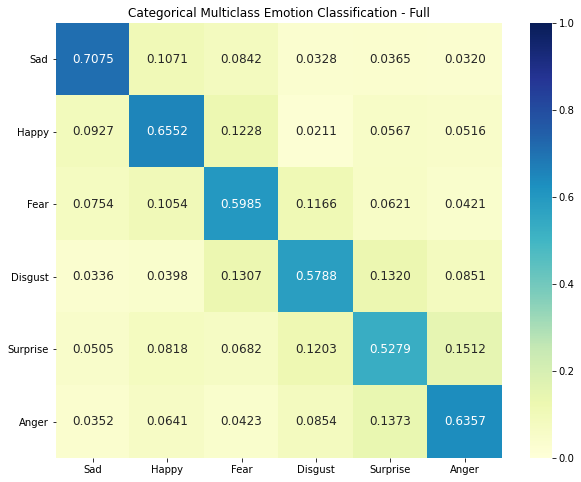

Mean and std of F1 MACRO is 0.6162 +- 0.0210
Mean and std of F1 WEIGHTED is 0.6163 +- 0.0210
Mean and std of accuracy is 0.6173 +- 0.0201


In [4]:
#conf_mat = np.zeros((2,2))
conf_mat = np.zeros((6,6))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

kfold = StratifiedKFold(n_splits=10, random_state=111, shuffle=True)

for train, test in kfold.split(features, labels):
    trainingFeatures = features[train,:,:,:]
    testFeatures = features[test,:,:,:]
    train_shape = trainingFeatures.shape
    test_shape = testFeatures.shape
    print("Train shape for fold %d : %s" % (f+1, train_shape))
    print("Test shape for fold %d : %s" % (f+1, test_shape))
    
    tf.keras.backend.clear_session() #to clear any previosuly obtiained models
    network = AlexNet_model()
    network.fit(trainingFeatures, labels_categorical[train,:], batch_size=batch_size, 
                epochs=epochs, verbose=1, validation_split=0.1)
    
    predicted_labelsNet = network.predict_classes(testFeatures, batch_size = 1, verbose=0)
    predicted_probsNet = network.predict_proba(testFeatures,batch_size=1,verbose=0)
    #cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0,1])
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[1,2,3,4,5,0])
    conf_mat = conf_mat+cm
        
    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['LA', 'HA'], rotation = 0)# for CSP and IIR
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for spectral
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)

#ax.set_xticklabels(['LA', 'HA'], rotation = 0) # for CSP and IIR
#ax.set_xticklabels(['NC', 'PD'], rotation = 0) # for spectral
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)

ax.set_title(title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

#Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat, 
                       'experiment':experiment, 'epochs':epochs})